## Introdução

Na primeira etapa do trabalho, foi realizada a pesquisa bibliográfica sobre medidas especificamente advindas da física e de sistemas complexos que pudessem ser usadas para prever eventos excepcionais em mercados financeiros. <br>
Após isso, foi feita a coleta de 2 anos de dados históricos de preços diários das dez criptomoedas mais capitalizadas e então realizada a análise de algumas de suas propriedades feitas nesse Notebook.

## Importando Bibliotecas

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
from scipy import stats
sns.set()

Função **get_all_files** serve para carregar todos os dados necessários do kaggle.

In [2]:
def get_all_files(path: str, file_type: str):
    files_path = []; files = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if f'.{file_type}' in filename:
                files.append(filename.replace(f'.{file_type}', ''))
                files_path.append(os.path.join(dirname, filename))
    return files_path, files

## Descrição dos dados
| Nome da Variável | Descrição     |
| ---------------- |:-------------:|
| Open Time        | Data de abertura do período |
| Close Time       | Data de fechamento do período      |
| Open             | Preço de abertura do período  |
| High             | Preço máximo do período  |
| Low              | Preço mínimo do período  |
| Close            | Preço de fechamento do período  |
| Volume           | Volume financeiro negociado do período  |

Função **data_handler** transforma as variáveis necessárias em numérico, calcula os retornos e os retornos logarítmicos e remove valores nulos do dataframe. <br>
* Close Price: para numérico <br>

Retorno Logarítmico:
$$ r_t = \ln(p_t) - \ln(p_{t-1}) $$
Sendo $p_t$ o preço de fechamento no tempo $t$.

In [3]:
def data_handler(df):
    df['close'] = pd.to_numeric(df['close'])
    df['log_return'] = np.log(df['close']) - np.log(df['close'].shift(1))
    df = df.dropna()
    return df

O código abaixo coloca todos os dataframes um um dicionário chamado "dfs" sendo suas **keys** correspondente ao nome da criptomoeda específica. Assim, dfs['BTCUSDT'] será um dataframe com os dados do Bitcoin.

In [4]:
path = '../input/cryptocurrency-data/'
files_path, files = get_all_files(path=path, file_type='csv')
dfs = {}
columns = ['open_time', 'close_time', 'open', 'high', 'low', 'close']
for file, file_path in zip(files, files_path):
    df = pd.read_csv(file_path)[columns]
    df = data_handler(df)
    dfs[file] = df

## Criptomoedas Escolhidas
Dez mais capitalizadas criptomoedas no dia 08 de Maio de 2021 de acordo com a CoinMarketCap:
1. Bitcoin: BTC
1. Ethereum: ETH
1. Binance Coin: BNB
1. Ripple: XRP
1. Cardano: ADA
1. Litecoin: LTC
1. Chainlink: LINK
1. Ethereum Classic: ETC
1. THETA: THETA
1. Tron: TRX

In [5]:
# ordenamento do dicionario de dataframes de acordo com a capitalização
order = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT',
 'LTCUSDT', 'LINKUSDT', 'ETCUSDT', 'THETAUSDT', 'TRXUSDT']
files = order
dfs = {your_key: dfs[your_key] for your_key in order}
index_map = {v: i for i, v in enumerate(order)}
sorted_dfs = sorted(dfs.items(), key=lambda pair: index_map[pair[0]])

dfs = {}
for df in sorted_dfs:
    dfs[df[0]] = df[1]

## Exemplo de dataset em sua forma final

In [6]:
dfs['BTCUSDT'].head(5)

,open_time,close_time,open,high,low,close,log_return
1,1557446400000,1557532799999,6209.95,6468.92,6172.00,6373.33,0.026093
2,1557532800000,1557619199999,6375.16,7343.99,6372.85,7076.22,0.104618
3,1557619200000,1557705599999,7076.24,7521.78,6750.00,6967.31,-0.015511
4,1557705600000,1557791999999,6968.24,8100.00,6870.00,7790.71,0.111703
5,1557792000000,1557878399999,7795.62,8366.00,7599.56,7947.56,0.019933


Função **multiple_plot** usada para fazer múltiplos plots para não replicar o código


In [7]:
def multiple_plot(title, feature, color, ylabel=None, xlabel=None, kind='feature', legend=False):
    ncols = 5
    nrows = 2
    fig, axes = plt.subplots(ncols, nrows, sharex=True, figsize=(15,10), dpi=300)
    fig.suptitle(title)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    files = order
    list_of_series = [files[i:i+nrows] for i in range(0, len(files), nrows)]
    for i in range(len(list_of_series)):
        sublist = list_of_series[i]
        for j in range(len(sublist)):
            if kind == 'feature':
                axes[i,j].plot(dfs[sublist[j]][feature], c=color)
                axes[i,j].title.set_text(sublist[j])
                if ylabel is not None:
                    axes[i,j].set_ylabel(ylabel)
                if xlabel is not None:
                    axes[i,j].set_xlabel(xlabel)
            elif kind == 'density':
                axes[i,j].title.set_text(sublist[j])
                props = dfs[sublist[j]]['log_return'].describe()
                mu = props['mean']
                sigma = props['std']
                xmin = min(dfs[sublist[j]]['log_return'])
                xmax = max(dfs[sublist[j]]['log_return'])
                x = np.linspace(xmin, xmax, 300)
                sns.histplot(dfs[sublist[j]]['log_return'], kde=True, stat='density', label='Histograma', ax=axes[i,j], color='black', bins=50)
                axes[i,j].plot(x, stats.norm.pdf(x, mu, sigma), c='red', label='Fit Gaussiano')
                if ylabel is not None:
                    axes[i,j].set_ylabel(ylabel)
                if xlabel is not None:
                    axes[i,j].set_xlabel(xlabel)
            elif kind=='qq_plot':
                stats.probplot(dfs[sublist[j]]['log_return'], dist="norm", rvalue=True, plot=axes[i,j])
                axes[i,j].title.set_text(sublist[j])
            if legend:
                axes[i,j].legend()

## Preços de Fechamento

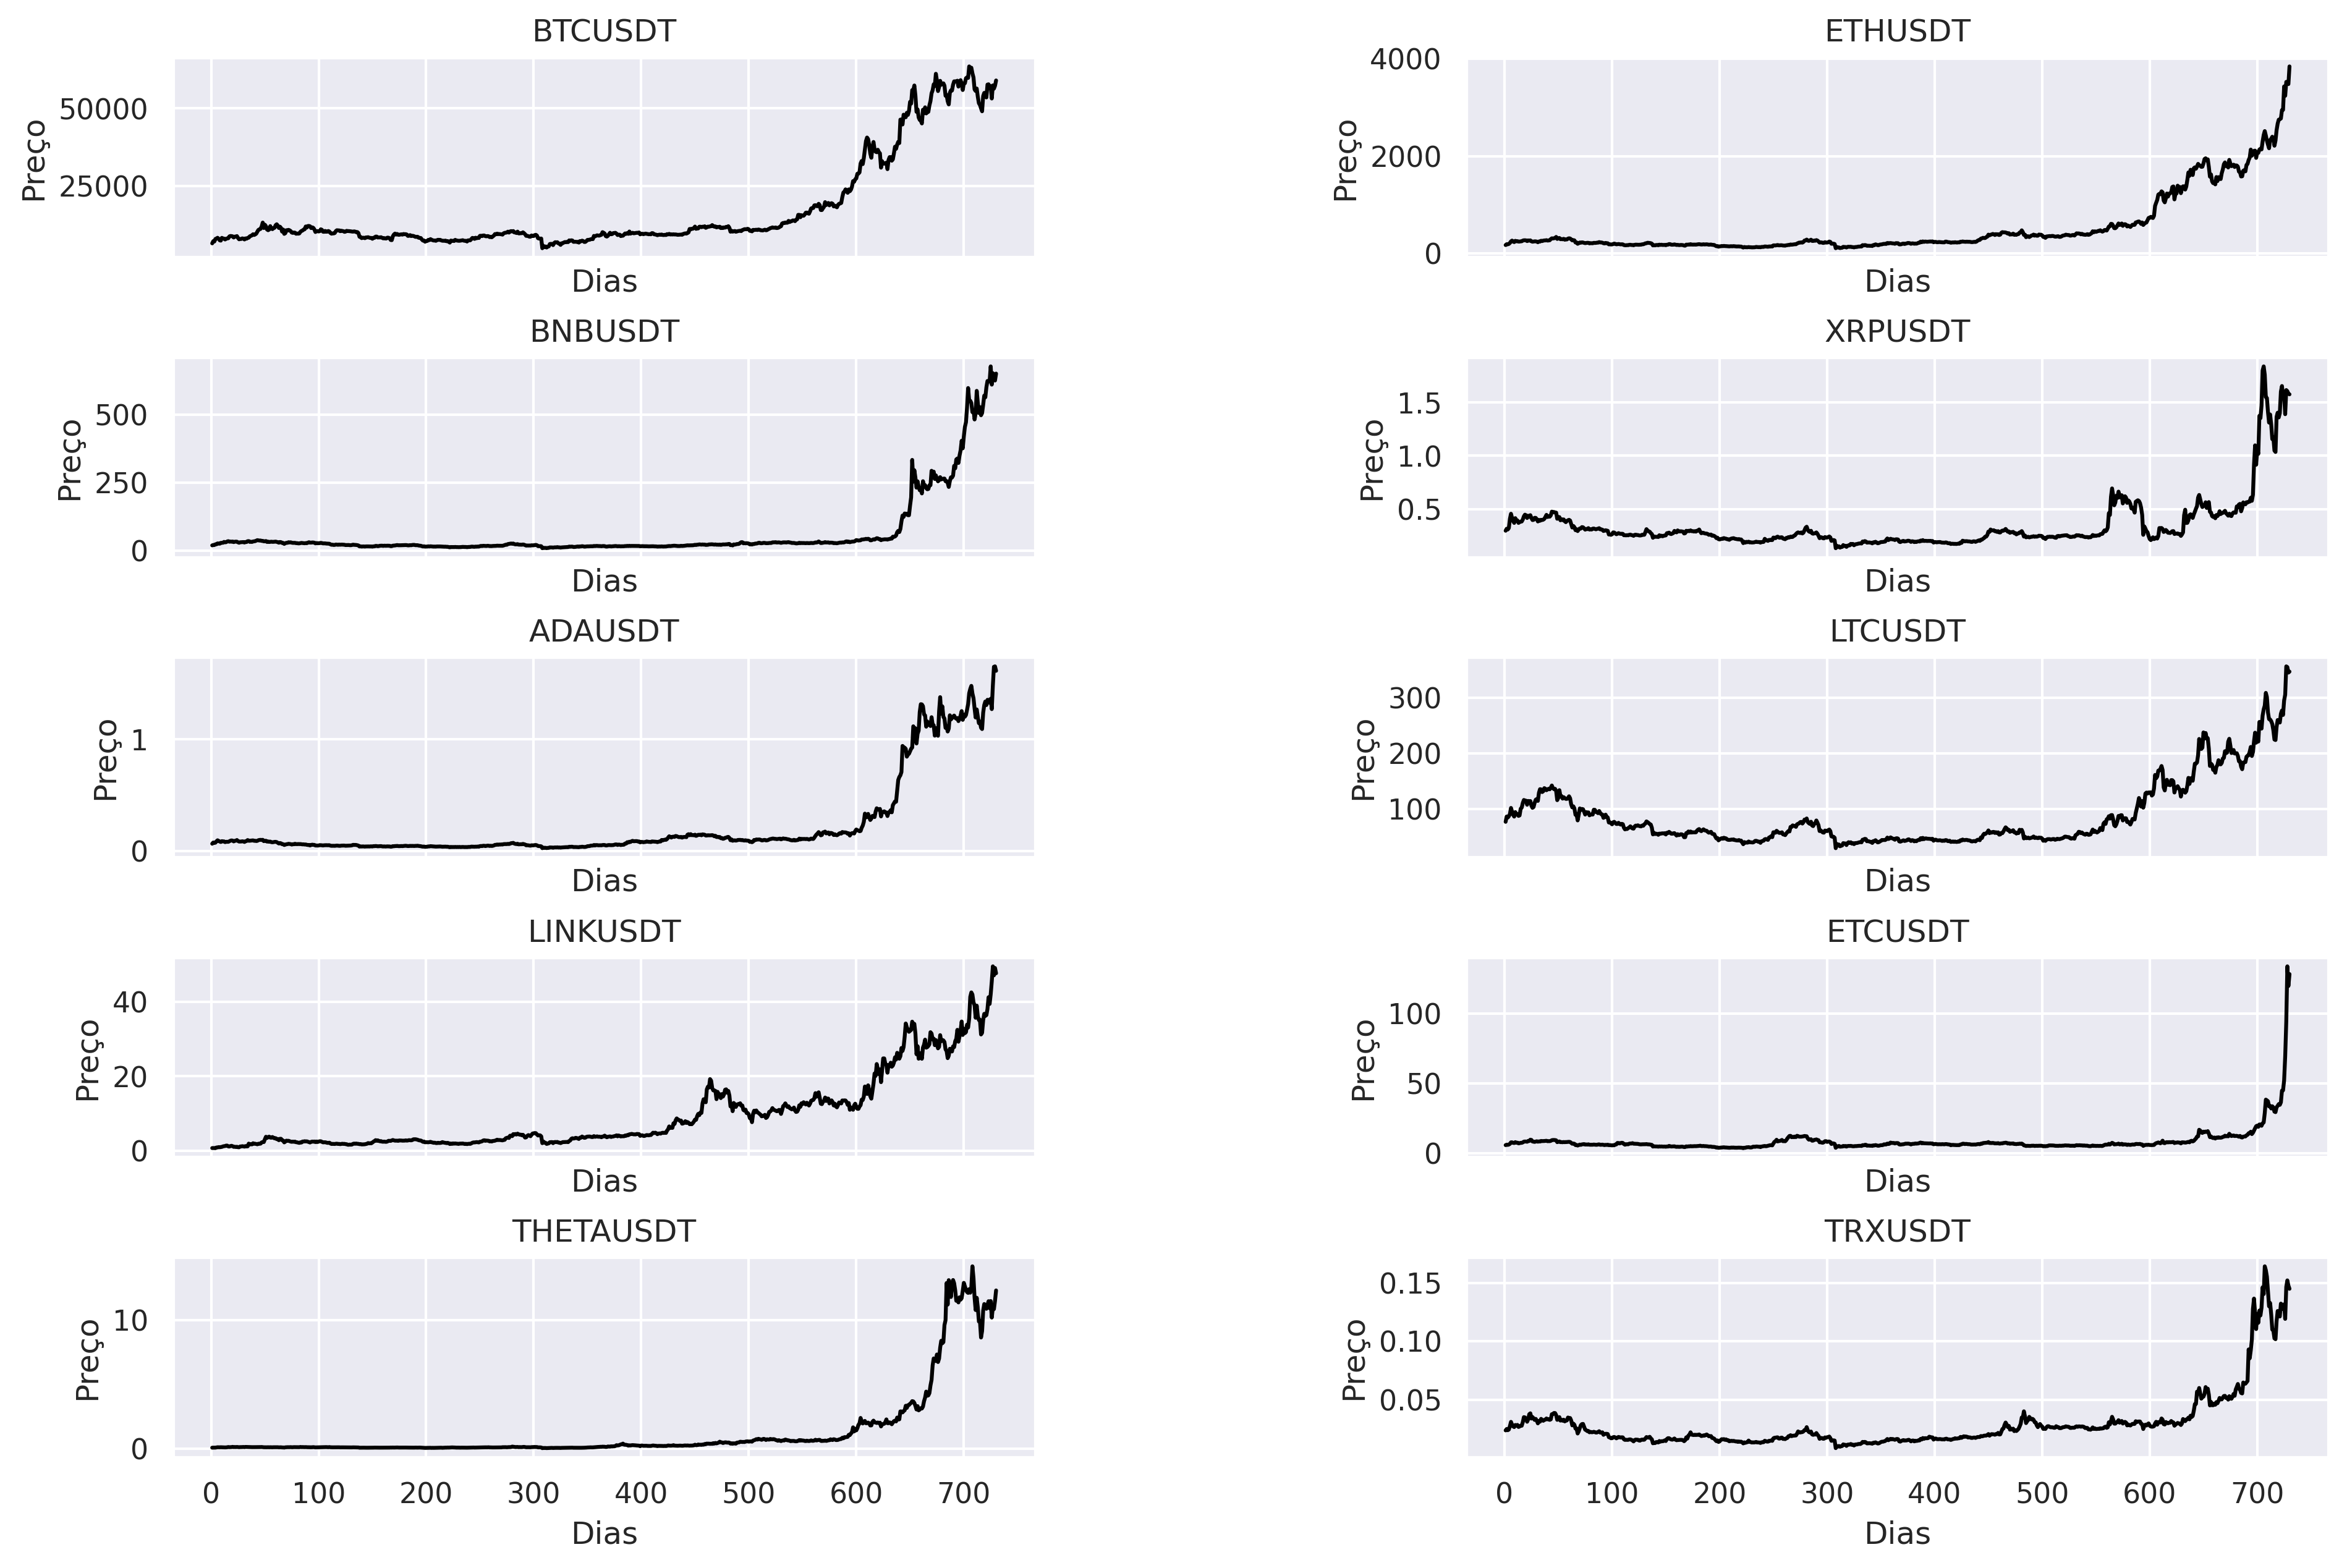

In [8]:
sns.set()
multiple_plot(feature='close',title='',ylabel='Preço',xlabel='Dias',color='black',kind='feature')
plt.savefig('prices.png', bbox_inches='tight', pad_inches=0, dpi=300)

## Teste de Estacionariedade 
Foi realizado um teste de raíz unitária conhecido como Teste Aumentado de Dickey-Fuller, através dele podemos checar se a nossas séries temporais são estacionárias ou não. A hipótese nula $H_0$ do teste é de que os dados possuem raiz unitária e portanto não é estacionário, caso contrário, na rejeição de $H_0$, concluímos que os dados são estacionários. <br>
O teste foi feito para os preços de cada criptomoeda e obtidos o **valor-p**, neste caso, utilizando-se um nível de significância de 5\%. Assim, caso o valor-p seja menor ou igual a 0.05 $p \leq 0.05 $, podemos rejeitar a hipótese nula e considerar a série estacionária.

In [9]:
def check_stationarity(x):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(x, autolag='AIC')
    p_value = result[1]
    return p_value

In [10]:
dickey_fuller = {}
for symbol in dfs:
    p = round(check_stationarity(dfs[symbol]['close']),4)
    if p <= 0.05:
        dickey_fuller[symbol] = [p, 'Sim']
    else:
        dickey_fuller[symbol] = [p, 'Não']
dickey_fuller_df = pd.DataFrame(dickey_fuller)
dickey_fuller_df.index=['Valor-p', 'Estacionário']
# print(dickey_fuller_df.T.to_latex())
dickey_fuller_df

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,LTCUSDT,LINKUSDT,ETCUSDT,THETAUSDT,TRXUSDT
Valor-p,0.9984,1.0,1.0,0.9974,0.9991,1.0,1.0,1.0,0.9952,1.0
Estacionário,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não


## Retornos logarítmicos

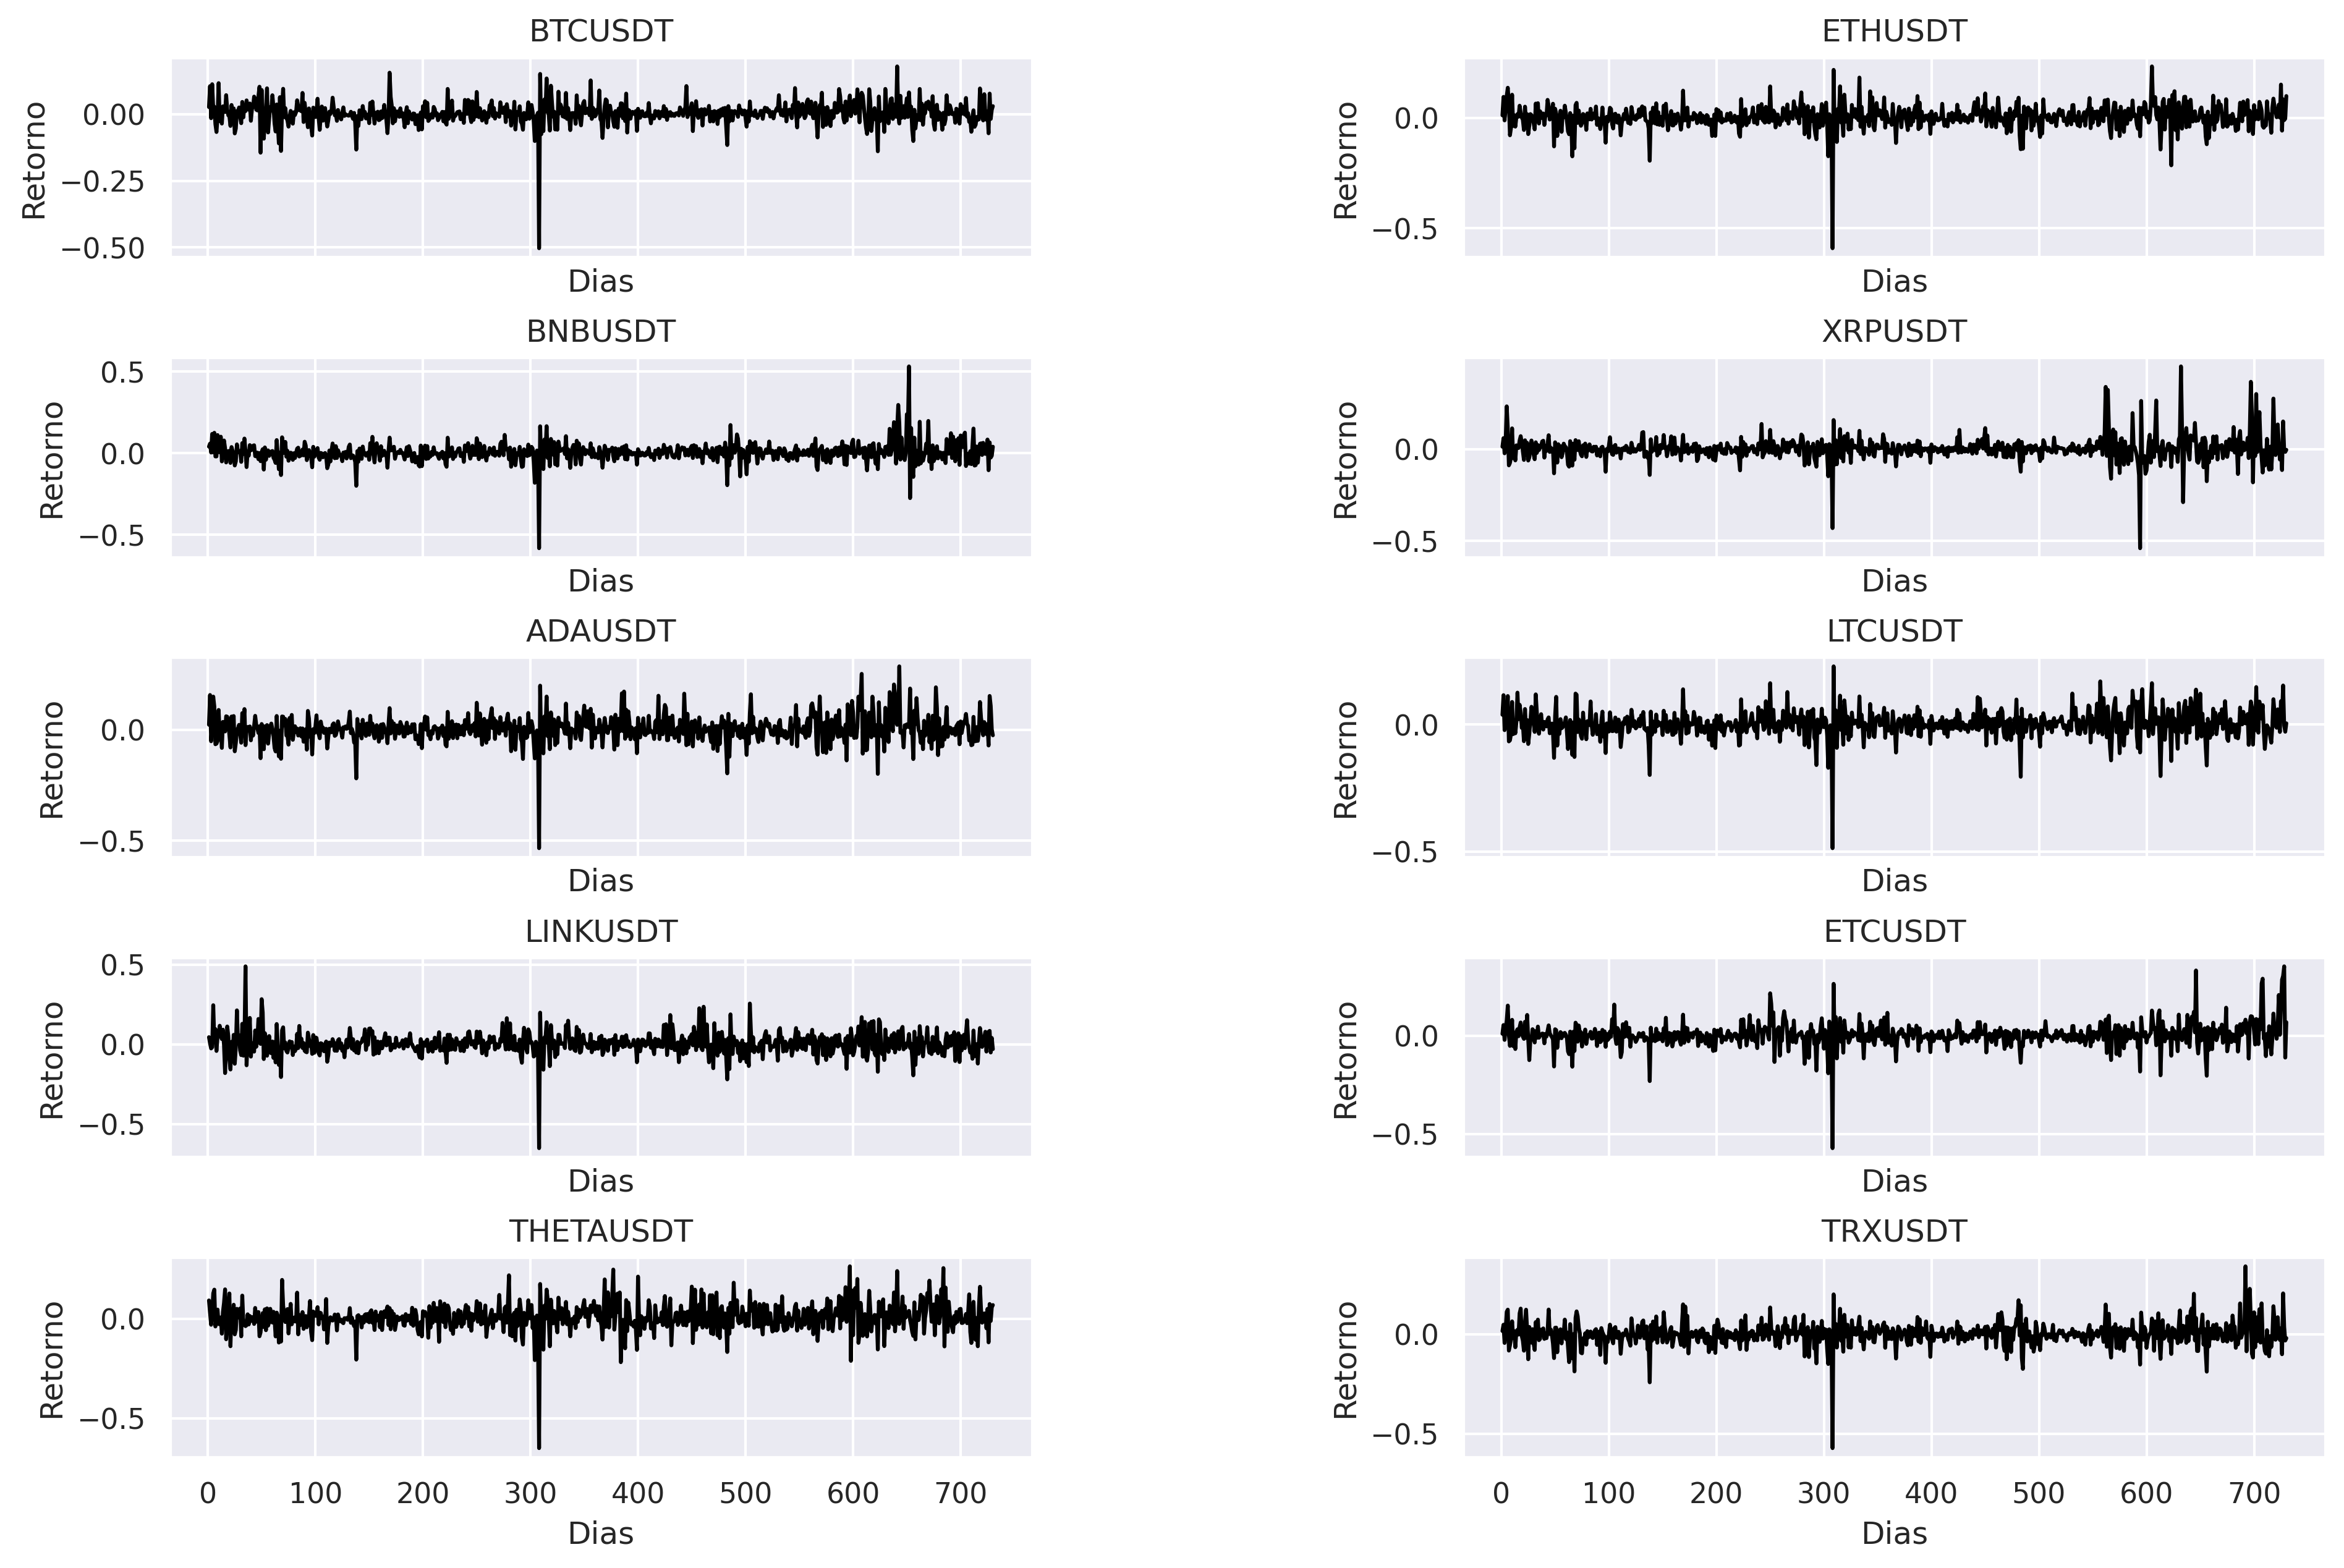

In [11]:
multiple_plot(feature='log_return',
             title='',
             ylabel='Retorno',
              xlabel='Dias',
             color='black',
             kind='feature')
plt.savefig('log_returns.png', dpi=300, pad_inches=0)

## Propriedades Estatísticas
As propriedades foram calculadas em cima dos valores dos retornos logarítmicos. <br>
Média e desvio padrão são mostrados em ordem ascendente nos gráficos plotados.
* Média
* Desvio Padrão
* Mínimo
* Mediana 
* Máxima<br>


In [12]:
df_properties = pd.DataFrame([])
for key in dfs:
    df_properties[key] = dfs[key]['log_return'].describe()
df_properties = df_properties.drop(['count', '25%', '75%'])
df_properties = df_properties.T
# print('Tabela Latex \n')
# print(df_properties.to_latex())
df_properties

,mean,std,min,50%,max
BTCUSDT,0.003085,0.042047,-0.502607,0.001780,0.178449
ETHUSDT,0.004264,0.052305,-0.590534,0.003243,0.233501
BNBUSDT,0.004850,0.059414,-0.582287,0.002782,0.532404
XRPUSDT,0.002294,0.064753,-0.538657,0.001120,0.450100
ADAUSDT,0.004471,0.060040,-0.533075,0.004701,0.286441
LTCUSDT,0.002112,0.053353,-0.486668,0.000747,0.229360
LINKUSDT,0.005905,0.070391,-0.649747,0.003920,0.489638
ETCUSDT,0.004294,0.061629,-0.573024,0.002794,0.353934
THETAUSDT,0.006919,0.069709,-0.649636,0.005121,0.262890
TRXUSDT,0.002511,0.060020,-0.571268,0.002390,0.342818


### Gráfico médias

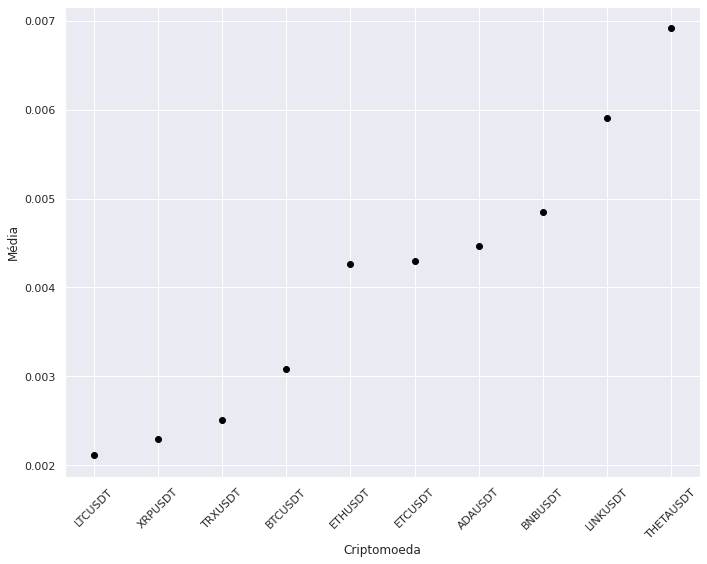

In [13]:
plt.figure(figsize=(10,8))
df_properties_to_plot = df_properties.sort_values(by=['mean'])
plt.scatter(df_properties_to_plot.index,df_properties_to_plot['mean'], color='black')
plt.xticks(rotation=45);
# plt.title('Médias dos Retornos em Ordem Ascendente')
plt.xlabel('Criptomoeda');
plt.ylabel('Média');
plt.tight_layout()
plt.savefig('mean.png', dpi=300)

### Gráfico dos desvios-padrões

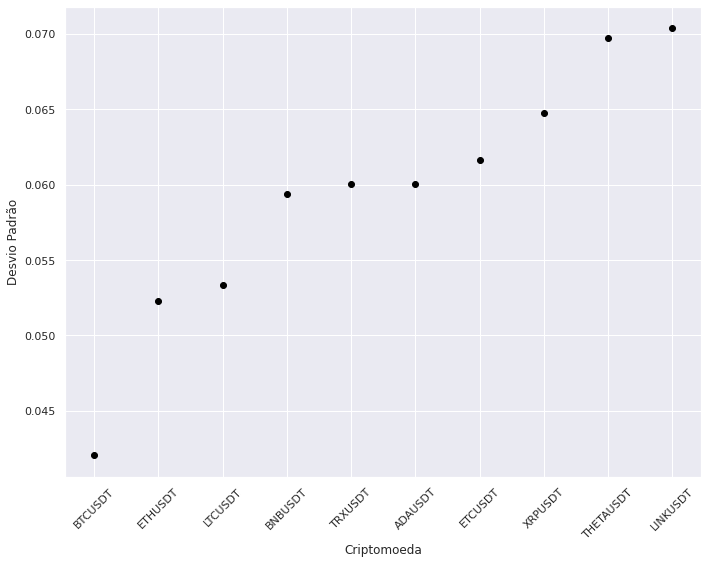

In [14]:
plt.figure(figsize=(10,8))
df_properties_to_plot = df_properties.sort_values(by=['std'])
plt.scatter(df_properties_to_plot.index,df_properties_to_plot['std'],c= 'black')
plt.xticks(rotation=45);
# plt.title('Desvio Padrão dos Retornos em Ordem Ascendente')
plt.xlabel('Criptomoeda');
plt.ylabel('Desvio Padrão');
plt.tight_layout()
plt.savefig('std.png', dpi=300)

## Distribuição dos Retornos

O gráfico dos retornos está em forma de densidade (normalizando as contagens dos histogramas de forma que a sua área seja igual a 1), os dados foram divididos em 50 áreas igualmente espaçadas. <br>
A linha em cor preta é uma aproximação da distribuição utilizando-se de Estimativa de Densidade Kernel, com kernel gaussiano (KDE), já implementada dentro da biblioteca Seaborn. A linha em vermelho representa o fit (ajuste de curva) de uma distribuição gaussiana utilizando-se das medidas calculadas anteriormente (média e desvio padrão).

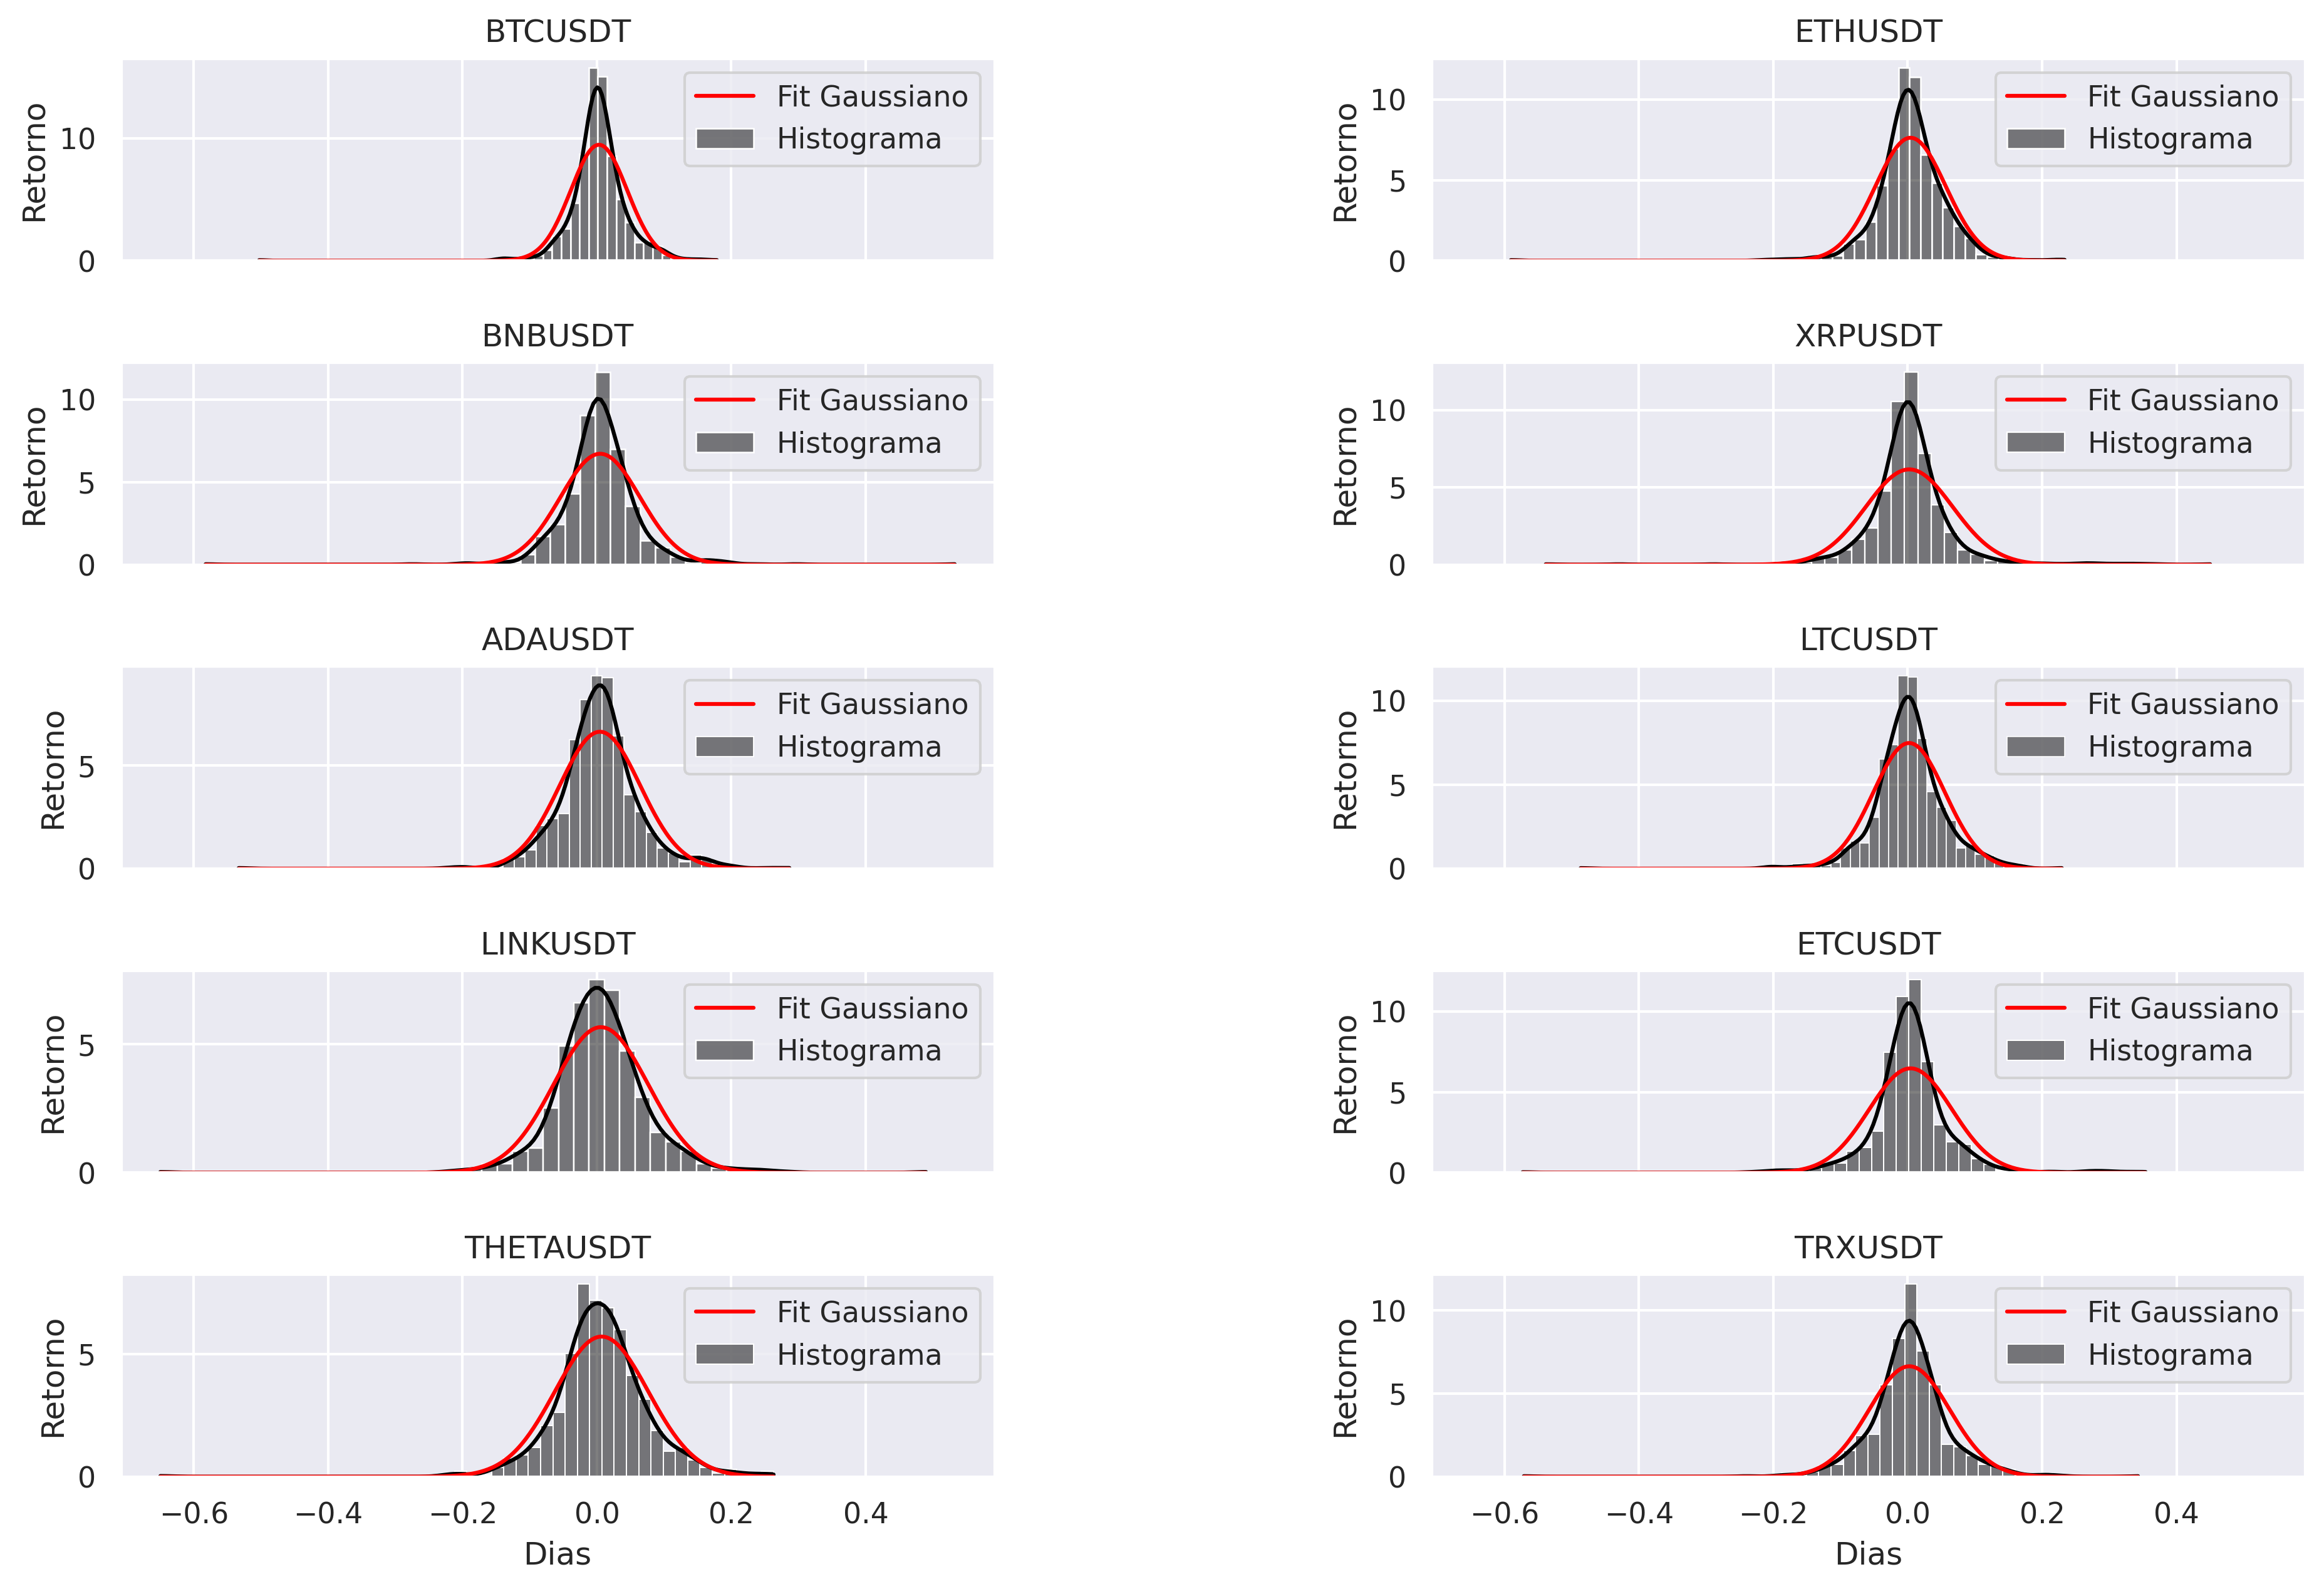

In [15]:
multiple_plot(feature='log_return',
             title='',
             ylabel='Retorno',
              xlabel='Dias',
             color='black',
             kind='density',
             legend=True)
plt.savefig('distributions.png', dpi=300, pad_inches=0)

## Matriz de Correlação

A matriz de correlação é uma matriz $\boldsymbol{C}$ de tamanho $M\times M$ onde cada elemento $C_{ij}$ é a correlação de escolha entre duas variáveis. Foram obtidas as correlações dos retornos entre cada uma das criptomoedas, sendo o tipo de correlação calculado através do coeficiente de Pearson $\rho$, com $\rho \in [-1,1]$. <br>
Desse modo, um coeficiente Pearson positivo e mais próximo de 1 indica que se o retorno da criptomoeda $X$ foi positivo, o retorno da criptomoeda $Y$ tende a ser positivo. Por outro lado, se o coeficiente for negativo e mais próximo de -1, indicaria que caso a criptomoeda $X$ tenha um retorno positivo, o retorno da criptomoeda $Y$ tende a ser negativo.

In [16]:
log_returns_df = pd.DataFrame([])
for key in dfs.keys():
    log_returns_df[f'{key}'] = dfs[key]['log_return']
log_returns_df

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,LTCUSDT,LINKUSDT,ETCUSDT,THETAUSDT,TRXUSDT
1,0.026093,0.011693,0.040458,0.013239,0.023233,0.038604,0.045789,0.010177,0.091699,0.017526
2,0.104618,0.095305,0.058860,0.059851,0.157358,0.115951,0.007284,0.054590,0.028376,0.049194
3,-0.015511,-0.011049,0.004197,-0.022570,-0.051080,-0.021715,-0.024893,-0.020989,-0.030459,-0.042437
4,0.111703,0.040271,0.118460,0.043933,0.034708,0.028276,-0.017152,0.036649,0.038294,0.023707
5,0.019933,0.099831,0.005694,0.232694,0.150173,0.044980,0.246049,0.077930,0.127914,0.114077
...,...,...,...,...,...,...,...,...,...,...
726,-0.071960,-0.057596,-0.104104,-0.113571,-0.070242,0.034531,0.079399,0.285754,-0.118708,-0.099140
727,0.076615,0.084403,0.066352,0.150634,0.153048,0.153977,0.085181,0.305182,0.073702,0.206747
728,-0.018316,-0.009846,-0.026630,-0.006530,0.108323,-0.003855,-0.050068,0.353934,-0.011345,0.037634
729,0.016201,-0.002927,-0.015402,-0.014770,0.002362,-0.027962,0.041031,-0.111310,0.057133,-0.030223


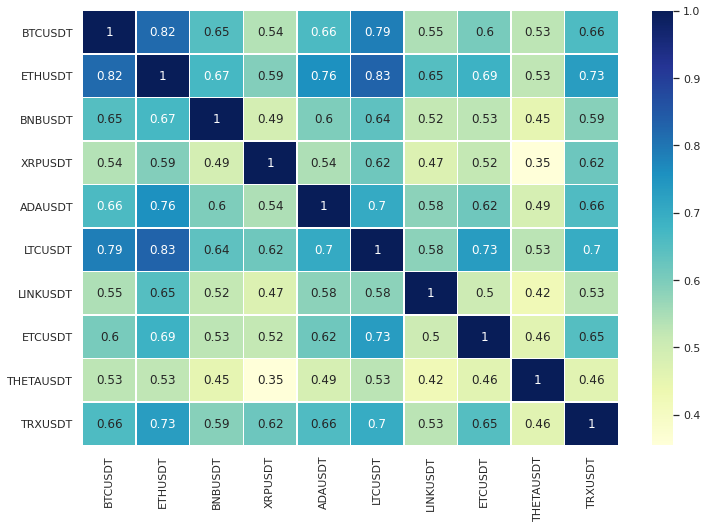

In [17]:
sns.set()
plt.figure(figsize=(12,8))
corr = log_returns_df.corr()
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True
# plt.title('Correlation Matrix Plot')
sns.heatmap(corr, annot=True, linewidths=.5, cmap="YlGnBu");
plt.savefig('corr.png', bbox_inches='tight', dpi=300)

Podemos perceber a partir da figura da matriz de correlação obtida acima que todas as criptomoedas possuem correlação positiva entre seus retornos, quase todas com valor $\rho > 0.50$. Os maiores valores de correlação são encontrados no Bitcoin, sendo o maior com o Ethereum ($\rho = 0.82$). Esse fato pode indicar que o Bitcoin, que é a mais capitalizada das criptomoedas, "comanda" o mercado, pois as demais criptomoedas tendem a seguir a sua performance.

In [18]:
# alguns testes

#distribution
# weights = np.ones_like(dfs['BTCUSDT']['log_return']) / len(dfs['BTCUSDT']['log_return'])
# a = plt.hist(dfs['BTCUSDT']['log_return'], weights=weights, bins=50);
# plt.clf();
# from scipy.optimize import curve_fit
# from scipy import asarray as ar,exp
# x = a[1][:-1]
# y = a[0]
# n = len(x)
# mean = sum(x*y)/n
# sigma = sum(y*(x-mean)**2)/n
# def gaus(x,a,x0,sigma):
#     return a*np.exp(-(x-x0)**2/(2*sigma**2))
# plt.figure(figsize=(12,8))
# plt.plot(a[1][:-1],a[0], '--o', label='dados', c='black')
# popt,pcov = curve_fit(gaus,x,y)
# plt.plot(x,gaus(x,*popt),'-',label='Fit Gaussiana', c='red')
# plt.legend()

# QQ plot Inspection

# plt.figure(figsize=(12,8))
# stats.probplot(dfs['BTCUSDT']['log_return'], dist="norm", plot=pylab, rvalue=True)
# plt.title('QQ Plot - BTCUSDT')
# pylab.show()